<font size=6><strong>Demo Notebook Feature Selection</strong></font>

# Initializing

## load packages and set constants

In [1]:
%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time
import importlib
import re
import math
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 60)
plt.rcParams["figure.figsize"] = (30, 15)
#plt.style.use('ggplot')
sns.set_style('whitegrid')

random_seed = 999

In [2]:
dict_model = {}
dict_model['LR'] = 'Logistic Regression'
dict_model['RF'] = 'Random Forest Classifier'
dict_model['AB'] = 'AdaBoost Classifier'
dict_model['EN'] = 'ElasticNet'
dict_model['SVC'] = 'C-Support Vector Classification'
dict_model['SGD'] = 'Stochastic Gradient Descent'
dict_model['kNN'] = 'Nearest Neighbors Classification'
dict_model['GPC'] = 'Gaussian Process Classification'
dict_model['DT'] = 'Decision Tree Classifier'
dict_model['GB'] = 'Gradient Boosting Classifier'

time: 56.3 ms


## Functions

In [3]:
def score_MCC(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    with np.errstate(divide='ignore',invalid='ignore'):
        mcc = ((tp * tn) -(fp * fn)) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    return tp, fp, tn, fn, mcc

def load_madelon(local=True):
    if local:
        #URLS for dataset included in package
        train_data_url='data/madelon/madelon_train.data'
        train_label_url='data/madelon/madelon_train.labels'
        test_data_url='data/madelon/madelon_valid.data'
        test_label_url='data/madelon/madelon_valid.labels'
    else:
        # URLS for dataset via UCI
        train_data_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.data'
        train_label_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.labels'
        test_data_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_valid.data'
        test_label_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_valid.labels'
    
    X_data = pd.read_csv(train_data_url, sep=" ", header=None)
    y_data = pd.read_csv(train_label_url, sep=" ", header=None)
    data = X_data.iloc[:,0:500]
    data['target'] = y_data[0]
    X_test = pd.read_csv(test_data_url, sep=" ", header=None)
    y_test = pd.read_csv(test_label_url, sep=" ", header=None)
    test = X_test.iloc[:,0:500]
    test['target'] = y_test[0]
    return data, test

def run_alg(dict_alg, X_train, X_test, y_train, y_test):
    col_names = ['algorithm', 'TP', 'FP', 'TN', 'FN', 'MCC']
    df = pd.DataFrame(columns=col_names)
    for key in dict_alg.keys():
        model = dict_alg[key]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # handling the continuos results and forcing them to binary
        if key in ['EN']:
            y_pred = [1 if i >=0 else -1 for i in y_pred]
        df = df.append(pd.DataFrame([dict(zip(col_names,[dict_model[key]] + list(score_MCC(y_test, y_pred))))]), ignore_index=True)
    return df[col_names] # forcing right layout

def run_tune_alg(dict_alg, dict_param, X_train, X_test, y_train, y_test):
    col_names = ['algorithm', 'TP', 'FP', 'TN', 'FN', 'MCC']
    df = pd.DataFrame(columns=col_names)
    for key in dict_alg.keys():
        print(key)
        model = dict_alg[key]
        param_grid = dict_param[key]
        grid_search = GridSearchCV(model, param_grid=param_grid)
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        if key in ['EN']:
            y_pred = [1 if i >=0 else -1 for i in y_pred]
        df = df.append(pd.DataFrame([dict(zip(col_names,[dict_model[key]] + list(score_MCC(y_test, y_pred))))]), ignore_index=True)
    return df[col_names] # forcing right layout

def prep_data(X, y, random_seed):
    return train_test_split(X, y, test_size=0.33, random_state=random_seed)

def prep_df(df_train, df_test):
    X_train = df_train.iloc[:,:-1]
    y_train = df_train.iloc[:,-1]
    X_test = df_test.iloc[:,:-1]
    y_test = df_test.iloc[:,-1]
    return X_train, X_test, y_train, y_test

time: 180 ms


## Loading Data Sets

In [4]:
df_train, df_test = load_madelon()

time: 423 ms


In [5]:
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,target
0,485,477,537,479,452,471,491,476,475,473,455,500,456,507,478,491,447,422,480,482,515,482,464,484,477,496,509,491,459,482,...,470,515,476,467,401,485,499,495,490,508,463,487,531,515,476,482,463,467,479,477,481,477,485,511,485,481,479,475,496,-1
1,483,458,460,487,587,475,526,479,485,469,434,483,465,503,472,478,469,518,495,491,478,530,462,494,549,469,516,487,475,486,...,478,465,479,482,549,470,506,481,494,492,448,492,447,598,507,478,483,492,485,463,478,487,338,513,486,483,492,510,517,-1
2,487,542,499,468,448,471,442,478,480,477,468,497,477,491,493,502,465,567,510,475,474,483,490,492,544,482,454,496,491,495,...,481,485,478,479,454,503,501,500,484,479,470,466,529,482,486,487,480,522,481,487,481,492,650,506,501,480,489,499,498,-1
3,480,491,510,485,495,472,417,474,502,476,455,520,437,472,481,436,503,522,488,468,492,488,476,479,477,485,506,476,472,506,...,481,457,476,481,602,500,503,481,487,465,473,477,515,525,468,487,458,489,490,491,480,474,572,454,469,475,482,494,461,1
4,484,502,528,489,466,481,402,478,487,468,432,494,493,434,505,497,486,471,467,476,455,517,483,465,512,552,505,464,472,419,...,476,500,479,483,560,474,486,459,494,509,456,472,520,468,482,473,473,498,485,488,479,452,435,486,508,481,504,495,511,1


time: 107 ms


In [6]:
df_train.shape

(2000, 501)

time: 54.6 ms


In [7]:
df_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,target
0,483,454,513,495,523,469,453,477,506,479,470,510,463,423,511,500,494,493,472,477,497,503,474,472,483,538,454,468,490,510,...,469,454,477,472,538,509,488,493,487,499,486,462,523,432,484,474,458,485,464,455,480,543,259,413,520,485,498,523,510,-1
1,485,508,493,487,478,472,504,476,479,475,533,495,427,456,482,481,471,466,476,476,485,470,490,488,504,490,483,478,491,490,...,476,439,478,481,429,481,493,501,492,480,465,474,528,472,483,472,492,469,468,486,480,535,534,514,452,484,495,548,477,-1
2,483,521,507,475,493,486,421,475,496,483,428,481,477,578,480,477,458,516,482,467,466,499,479,476,512,547,457,461,479,474,...,478,494,478,486,517,478,494,462,495,503,502,462,462,507,480,472,446,508,477,491,476,498,495,508,528,486,465,508,503,-1
3,474,504,576,480,553,483,524,478,483,483,467,547,484,430,489,492,476,481,443,486,508,492,484,468,559,465,491,503,472,485,...,481,540,477,485,386,477,469,474,484,485,506,493,465,562,478,474,498,482,481,521,475,470,463,509,525,479,467,552,517,1
4,495,474,523,479,495,488,485,476,497,478,510,479,514,446,470,487,480,441,467,485,474,502,492,476,460,505,481,506,469,457,...,482,487,478,471,527,519,478,520,478,470,455,500,488,480,495,481,498,495,464,510,471,522,343,509,520,475,493,506,491,-1


time: 212 ms


In [8]:
df_test.shape

(600, 501)

time: 37.3 ms


# Setting up stack of algorithms

- Logistic Regression
- Random Forest
- Ada Boost
- Elastic Net
- SVC (rbf kernel)
- Stochastic Gradient Descent
- Nearest Neighbors Classification
- Gaussian Process Classification (GPC)
- Decision Tree
- Gradient Boosting Classifier

## scoring via Matthews Correlation Coefficient (MCC):

for more details refer https://en.wikipedia.org/wiki/Matthews_correlation_coefficient

$
MCC = \frac{TP \times TN – FP \times FN}{\sqrt{ (TP +FP) \times (TP + FN) \times (TN + FP) \times (TN + FN)}}
$

## output from each algorithm to be captured:

| algorithm | TP | FP | TN | FN | MCC |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | | | | | |
| Random Forest | | | | | |
| Ada Boost | | | | | |
| Elastic Net | | | | | |
| SVC (rbf kernel) | | | | | |
| Stochastic Gradient Descent | | | | | |
| Nearest Neighbors Classification | | | | | |
| Gaussian Process Classification (GPC) | | | | | |
| Decision Tree | | | | | | 

## Data preparation:

In [9]:
X_train = df_train.iloc[:,:-1]
X_test = df_test.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
y_test = df_test.iloc[:,-1]

time: 52 ms


# Naive approach: Fit full dataset to default algorithm

In [10]:
dict_alg = {}
dict_alg['LR'] = LogisticRegression(random_state=random_seed)
dict_alg['RF'] = RandomForestClassifier(random_state=random_seed)
dict_alg['AB'] = AdaBoostClassifier(random_state=random_seed)
dict_alg['EN'] = ElasticNet(random_state=random_seed)
dict_alg['SVC'] = SVC(random_state=random_seed) # rbf kernel is default
dict_alg['SGD'] = SGDClassifier(random_state=random_seed)
dict_alg['kNN'] = KNeighborsClassifier()
dict_alg['GPC'] = GaussianProcessClassifier(random_state=random_seed)
dict_alg['DT'] = DecisionTreeClassifier(random_state=random_seed)
dict_alg['GB'] = GradientBoostingClassifier(random_state=random_seed)

time: 42.6 ms


In [11]:
df_naive = run_alg(dict_alg, X_train, X_test, y_train, y_test)

time: 44.6 s


In [12]:
df_naive

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,174,120,180,126,0.180036
1,Random Forest Classifier,143,77,223,157,0.228266
2,AdaBoost Classifier,183,124,176,117,0.196720
3,ElasticNet,162,119,181,138,0.143622
4,C-Support Vector Classification,300,300,0,0,NaN
5,Stochastic Gradient Descent,254,240,60,46,0.061180
6,Nearest Neighbors Classification,198,83,217,102,0.384104
7,Gaussian Process Classification,0,0,300,300,NaN
8,Decision Tree Classifier,237,83,217,63,0.514478
9,Gradient Boosting Classifier,221,71,229,79,0.500178


time: 62.2 ms


Obviously, the results are a mixed bag: <br>
As this is a truly naive approach, the results are not truly replicable, as the random states are not set.<br>
- In general, LR, RF, AB EN, SGD are better than random guessing, althought not by much.
- SVC, GPC are either really bad or inconclusive as they predict all results in the same class.
- kNN DT and GB are not really bad, but far from desireable.

It takes less then 45 seconds to run all models on this dataset.

Best is around 0.51.

# Brute force approach: tune algorithm for optimal parameters and fit full dataset

In [13]:
dict_param = {}
dict_param['LR'] = {'max_iter': [10, 30, 60, 100, 300, 600, 1000],
                    'solver': ['liblinear', 'saga'],
                    }
dict_param['RF'] = {'n_estimators': [100, 300, 600, 1000],
                    'max_features': [3, 5, 7],
                    'max_depth': [2, 4, 6, 8],
                    'min_samples_split': [2, 4, 6, 8],
                    'min_samples_leaf': [1, 2, 4]
                    }
dict_param['AB'] = {'n_estimators': [100, 300, 600, 1000],
                    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.6]
                    }
dict_param['EN'] = {'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
                    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                    'max_iter': [100, 500, 1000]
                    }
dict_param['SVC']= {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'C': [0.01, 0.05, 0.1, 0.5, 1.0],
                    'degree': [2, 3, 4, 5]
                    }
dict_param['SGD']= {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                    'alpha': [0.0001, 0.001, 0.01, 0.1],
                    'fit_intercept': [True, False]
                    }
dict_param['kNN']= {'n_neighbors': [2, 4, 6, 8, 10],
                    }
dict_param['GPC']= {'multi_class': ['one_vs_rest', 'one_vs_one'],
                    'max_iter_predict': [30, 60, 100, 300]
                    }
dict_param['DT'] = {'criterion': ['gini', 'entropy'],
                    'max_depth': [3, 6, 10, 30, 100],
                    'min_samples_split': [2, 3, 6, 10, 30],
                    'min_samples_leaf': [1, 3, 6, 10, 30],
                    'presort': [True, False]
                    }
dict_param['GB'] = {'learning_rate': [0.01, 0.05, 0.1, 0.15],
                    'n_estimators': [50, 100, 300, 600],
                    'max_depth': [3, 6, 10, 30],
                    'min_samples_split': [2, 4, 8],
                    'min_samples_leaf': [2, 4, 8]}


time: 67.7 ms


In [14]:
df_brute = run_tune_alg(dict_alg, dict_param, X_train, X_test, y_train, y_test)

LR
RF
AB
EN
SVC
SGD
kNN
GPC
DT
GB
time: 4d 2h 44min 57s


In [15]:
df_brute

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,172,106,194,128,0.220594
1,Random Forest Classifier,182,102,198,118,0.267047
2,AdaBoost Classifier,194,124,176,106,0.233754
3,ElasticNet,165,124,176,135,0.136759
4,C-Support Vector Classification,198,112,188,102,0.286826
5,Stochastic Gradient Descent,254,240,60,46,0.061180
6,Nearest Neighbors Classification,178,38,262,122,0.486111
7,Gaussian Process Classification,0,0,300,300,NaN
8,Decision Tree Classifier,250,70,230,50,0.601338
9,Gradient Boosting Classifier,263,47,253,37,0.720400


time: 63.9 ms


results: Best around 0.72, but the runtime was over 4 days (nearly 99 hours)!

# Univariant Feature selection (without tuning)

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.

The number of "good" features needs to be preselected. In this example, 10% (or 50 features out of 500) is chosen.

In [16]:
select = SelectKBest(chi2, k=50)
select.fit(X_train, y_train)
X_train_select = select.transform(X_train)
X_test_select = select.transform(X_test)

time: 69.8 ms


In [17]:
dict_alg = {}
dict_alg['LR'] = LogisticRegression(random_state=random_seed)
dict_alg['RF'] = RandomForestClassifier(random_state=random_seed)
dict_alg['AB'] = AdaBoostClassifier(random_state=random_seed)
dict_alg['EN'] = ElasticNet(random_state=random_seed)
dict_alg['SVC'] = SVC(random_state=random_seed) # rbf kernel is default
dict_alg['SGD'] = SGDClassifier(random_state=random_seed)
dict_alg['kNN'] = KNeighborsClassifier()
dict_alg['GPC'] = GaussianProcessClassifier(random_state=random_seed)
dict_alg['DT'] = DecisionTreeClassifier(random_state=random_seed)
dict_alg['GB'] = GradientBoostingClassifier(random_state=random_seed)

time: 35.1 ms


In [18]:
df_univariant = run_alg(dict_alg, X_train_select, X_test_select, y_train, y_test)

time: 6.28 s


In [19]:
df_univariant

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,158,123,177,142,0.116901
1,Random Forest Classifier,200,45,255,100,0.525575
2,AdaBoost Classifier,178,129,171,122,0.163378
3,ElasticNet,164,121,179,136,0.143513
4,C-Support Vector Classification,300,300,0,0,NaN
5,Stochastic Gradient Descent,298,292,8,2,0.078113
6,Nearest Neighbors Classification,241,52,248,59,0.630172
7,Gaussian Process Classification,0,0,300,300,NaN
8,Decision Tree Classifier,237,73,227,63,0.546971
9,Gradient Boosting Classifier,226,69,231,74,0.523406


time: 61.1 ms


results: Best around 0.63, with a run time of under 10 seconds.

# Recursive Feature Elimination (without tuning)

In [20]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train)
#clf.feature_importances_ 

time: 143 ms


In [21]:
model = SelectFromModel(clf, prefit=True)
X_train_rfe = model.transform(X_train)
X_test_rfe = model.transform(X_test)

time: 58.4 ms


In [22]:
dict_alg = {}
dict_alg['LR'] = LogisticRegression(random_state=random_seed)
dict_alg['RF'] = RandomForestClassifier(random_state=random_seed)
dict_alg['AB'] = AdaBoostClassifier(random_state=random_seed)
dict_alg['EN'] = ElasticNet(random_state=random_seed)
dict_alg['SVC'] = SVC(random_state=random_seed) # rbf kernel is default
dict_alg['SGD'] = SGDClassifier(random_state=random_seed)
dict_alg['kNN'] = KNeighborsClassifier()
dict_alg['GPC'] = GaussianProcessClassifier(random_state=random_seed)
dict_alg['DT'] = DecisionTreeClassifier(random_state=random_seed)
dict_alg['GB'] = GradientBoostingClassifier(random_state=random_seed)

time: 63 ms


In [23]:
df_recursive = run_alg(dict_alg, X_train_rfe, X_test_rfe, y_train, y_test)

time: 12.9 s


In [24]:
df_recursive

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,159,139,161,141,0.066668
1,Random Forest Classifier,198,61,239,102,0.460992
2,AdaBoost Classifier,195,134,166,105,0.204290
3,ElasticNet,164,119,181,136,0.150241
4,C-Support Vector Classification,298,294,6,2,0.058124
5,Stochastic Gradient Descent,287,276,24,13,0.076215
6,Nearest Neighbors Classification,244,62,238,56,0.606788
7,Gaussian Process Classification,0,0,300,300,NaN
8,Decision Tree Classifier,237,73,227,63,0.546971
9,Gradient Boosting Classifier,235,71,229,65,0.546776


time: 47.2 ms


results: Best around 0.61, with a run time of under 15 seconds.

# Dimensionality Reduction with Principal component analysis (PCA) (without tuning)

In [25]:
pca = PCA(n_components=50)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

time: 216 ms


In [26]:
dict_alg = {}
dict_alg['LR'] = LogisticRegression(random_state=random_seed)
dict_alg['RF'] = RandomForestClassifier(random_state=random_seed)
dict_alg['AB'] = AdaBoostClassifier(random_state=random_seed)
dict_alg['EN'] = ElasticNet(random_state=random_seed)
dict_alg['SVC'] = SVC(random_state=random_seed) # rbf kernel is default
dict_alg['SGD'] = SGDClassifier(random_state=random_seed)
dict_alg['kNN'] = KNeighborsClassifier()
dict_alg['GPC'] = GaussianProcessClassifier(random_state=random_seed)
dict_alg['DT'] = DecisionTreeClassifier(random_state=random_seed)
dict_alg['GB'] = GradientBoostingClassifier(random_state=random_seed)

time: 38.5 ms


In [27]:
df_pca = run_alg(dict_alg, X_train_pca, X_test_pca, y_train, y_test)

time: 7.16 s


In [28]:
df_pca

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,170,120,180,130,0.166759
1,Random Forest Classifier,170,88,212,130,0.276052
2,AdaBoost Classifier,179,130,170,121,0.163407
3,ElasticNet,181,119,181,119,0.206667
4,C-Support Vector Classification,300,300,0,0,NaN
5,Stochastic Gradient Descent,162,131,169,138,0.103361
6,Nearest Neighbors Classification,239,73,227,61,0.553777
7,Gaussian Process Classification,0,0,300,300,NaN
8,Decision Tree Classifier,226,84,216,74,0.473597
9,Gradient Boosting Classifier,222,63,237,78,0.530664


time: 50.8 ms


results: Best around 0.55, with a run time of under 10 seconds.

# Selecting important features based on algorithm (without tuning)

In [29]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
#model.feature_importances_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

time: 297 ms


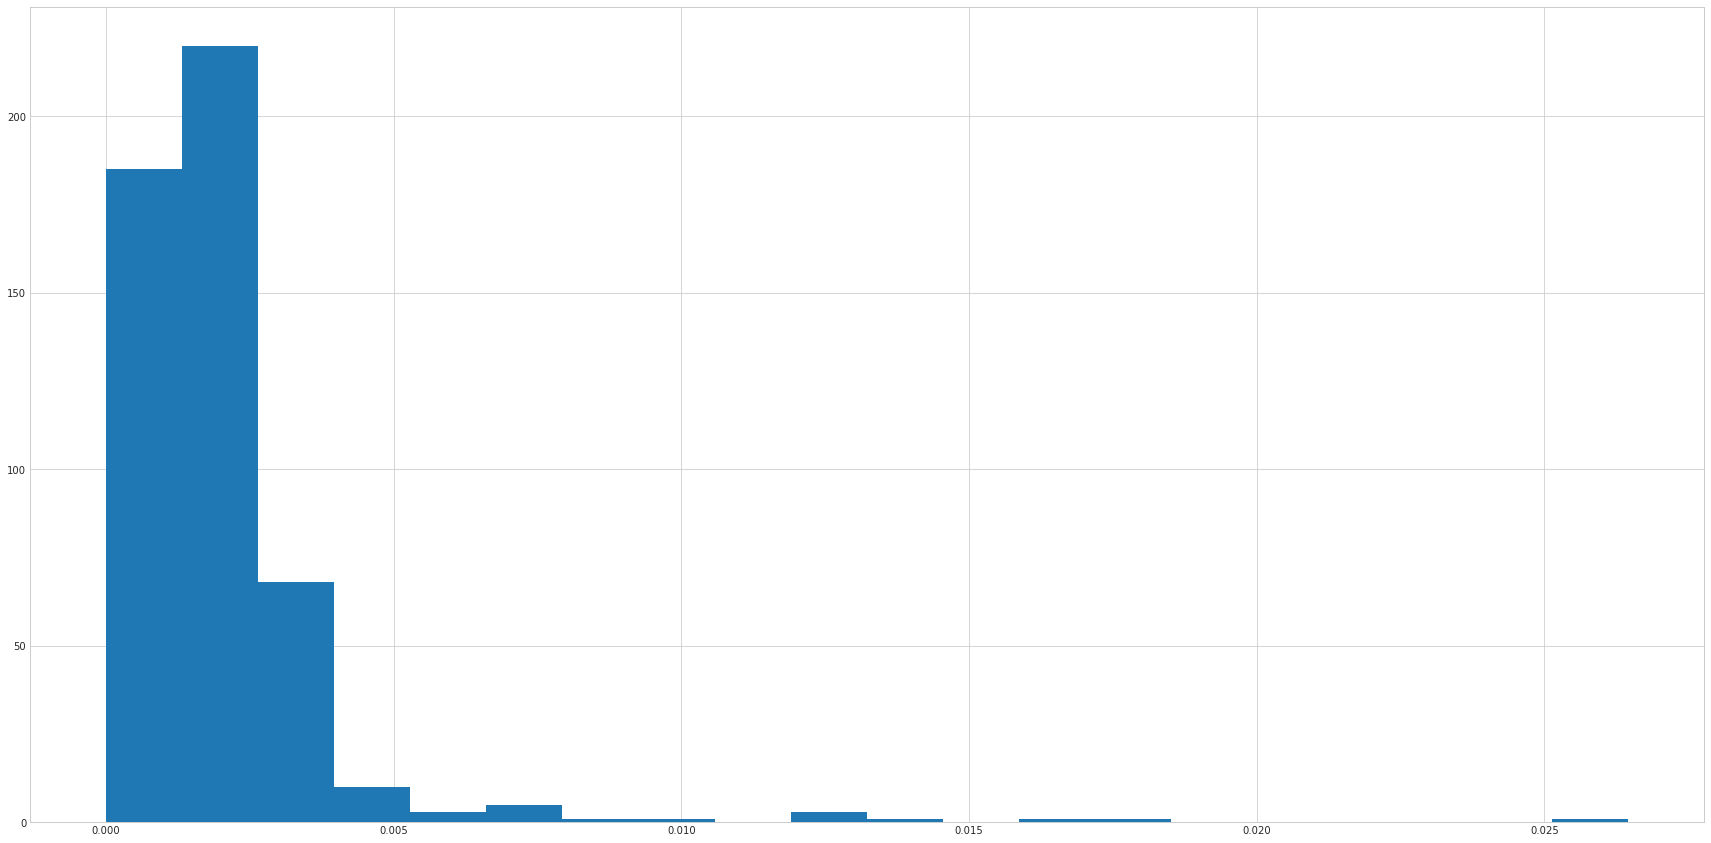

time: 1.07 s


In [30]:
plt.hist(model.feature_importances_, bins=20); 

Looks like features with feature importance <= 0.0025(approx.) are the bulk. So let's exclude those.

In [31]:
li_feat_use = [i for i in range(len(model.feature_importances_)) if model.feature_importances_[i] > 0.0025]
X_train_rffi = df_train[li_feat_use]
X_test_rffi = df_test[li_feat_use]

time: 595 ms


In [32]:
dict_alg = {}
dict_alg['LR'] = LogisticRegression(random_state=random_seed)
dict_alg['RF'] = RandomForestClassifier(random_state=random_seed)
dict_alg['AB'] = AdaBoostClassifier(random_state=random_seed)
dict_alg['EN'] = ElasticNet(random_state=random_seed)
dict_alg['SVC'] = SVC(random_state=random_seed) # rbf kernel is default
dict_alg['SGD'] = SGDClassifier(random_state=random_seed)
dict_alg['kNN'] = KNeighborsClassifier()
dict_alg['GPC'] = GaussianProcessClassifier(random_state=random_seed)
dict_alg['DT'] = DecisionTreeClassifier(random_state=random_seed)
dict_alg['GB'] = GradientBoostingClassifier(random_state=random_seed)

time: 43.2 ms


In [33]:
df_feat_imp = run_alg(dict_alg, X_train_rffi, X_test_rffi, y_train, y_test)

time: 8.24 s


In [34]:
df_feat_imp

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,175,117,183,125,0.193402
1,Random Forest Classifier,195,58,242,105,0.462376
2,AdaBoost Classifier,187,111,189,113,0.253339
3,ElasticNet,175,121,179,125,0.180016
4,C-Support Vector Classification,299,300,0,1,-0.040859
5,Stochastic Gradient Descent,273,252,48,27,0.105830
6,Nearest Neighbors Classification,245,64,236,55,0.603605
7,Gaussian Process Classification,0,0,300,300,NaN
8,Decision Tree Classifier,239,70,230,61,0.563587
9,Gradient Boosting Classifier,223,73,227,77,0.500044


time: 50.2 ms


results: Best around 0.60, with a run time of around 10 seconds.

# reference results (without tuning)

## secret sauce
runtime: approx: 1 min. 45 sec.

In [35]:
from boruta import BorutaPy
X = X_train.values
y = y_train.ravel()
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2)
feat_selector.fit(X,y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	474
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	7
Rejected: 	474
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	7
Rejected: 	474
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	7
Rejected: 	474
Iteration: 	12 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	13 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	14 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	15 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	16 / 100
Confirmed: 	19
Tenta

BorutasPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=132, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7f4728010510>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7f4728010510>,
     two_step=True, verbose=2)

time: 1min 39s


In [36]:
X_train_br = feat_selector.transform(X_train.values)
X_test_br = feat_selector.transform(X_test.values)

time: 31.4 ms


## you can see

In [37]:
dict_alg = {}
dict_alg['LR'] = LogisticRegression(random_state=random_seed)
dict_alg['RF'] = RandomForestClassifier(random_state=random_seed)
dict_alg['AB'] = AdaBoostClassifier(random_state=random_seed)
dict_alg['EN'] = ElasticNet(random_state=random_seed)
dict_alg['SVC'] = SVC(random_state=random_seed) # rbf kernel is default
dict_alg['SGD'] = SGDClassifier(random_state=random_seed)
dict_alg['kNN'] = KNeighborsClassifier()
dict_alg['GPC'] = GaussianProcessClassifier(random_state=random_seed)
dict_alg['DT'] = DecisionTreeClassifier(random_state=random_seed)
dict_alg['GB'] = GradientBoostingClassifier(random_state=random_seed)

time: 42.2 ms


In [38]:
df_reference = run_alg(dict_alg, X_train_br, X_test_br, y_train, y_test)

time: 5.26 s


In [39]:
df_reference

,algorithm,TP,FP,TN,FN,MCC
0,Logistic Regression,174,118,182,126,0.186733
1,Random Forest Classifier,255,41,259,45,0.713397
2,AdaBoost Classifier,207,114,186,93,0.310762
3,ElasticNet,179,118,182,121,0.203344
4,C-Support Vector Classification,2,0,300,298,0.057831
5,Stochastic Gradient Descent,300,300,0,0,NaN
6,Nearest Neighbors Classification,270,38,262,30,0.773608
7,Gaussian Process Classification,4,0,300,296,0.081923
8,Decision Tree Classifier,256,51,249,44,0.683519
9,Gradient Boosting Classifier,246,53,247,54,0.643337


time: 50.9 ms


results: Best around 0.77, with a run time of around 5 seconds.

# Summary:

| approach | best | runner-up | time|
| --- | --- | --- | --- | 
| naive | 0.51 | 0.50 | < 45 sec. |
| brute force | 0.72 | 0.60 | < 99 hrs. (4 days, 3 hrs.) |
| univ. feat. sel. | 0.63 | 0.55 | < 10 sec. |
| rec. feat elim. | 0.61 | 0.55 | < 15 sec. |
| dim reduction w/ PCA | 0.55 | 0.53 | < 10 sec. |
| selecting important feat | 0.60 | 0.56 | < 10 sec.(\*) |
| reference results | 0.77 | 0.71 | < 5 sec.(\*\*) |

(\*) with manual preparation of a few minutes<br>
(\*\*) with manual / machine preparation. a few minutes to include the code, approx. 100 sec. to run the machine part